## Initial Setup

In [2]:
#Importing Libraries
import pandas as pd
import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
from pytictoc import TicToc
import talib
import numpy as np
import mplfinance as mpf
from talib import abstract
t=TicToc()
import warnings
warnings.filterwarnings('ignore')

### Functions

In [3]:
##Getting Patterns

def get_patterns(data=None,ticker_column = 'ticker',mute=False):
    #from talib import abstract
    result = pd.DataFrame()
    tickers = data[ticker_column].unique()
    x=[]
    attr = talib.get_function_groups()['Pattern Recognition']
    for i in tickers:
        df = data[data[ticker_column]==i]
        for a in attr:
            df[a] = (getattr(abstract,a)(df))/100
        result = pd.concat([result,df])
        x.append(i)
        if mute is False:
            print(i + " Patterns Appended Successfully")
            print(result.shape)
            print(str(len(x)) + " of "+ str(len(tickers)) + " Done ")
        else:
            pass
    return result

#Creating Indicators

def get_indicators(data=None,ticker_column = 'ticker',price_column="close",mute=False):
    result = pd.DataFrame()
    tickers = data[ticker_column].unique()
    x=[]
    for i in tickers:
        df = data[data[ticker_column]==i]
        df["Vol_over_30DAvg"] = df["volume"]/df["volume"].rolling(window=30).mean()
        df["Vol_over_10DAvg"] = df["volume"]/df["volume"].rolling(window=10).mean()
        df["Perc_From_200D_H"] = ((df[price_column]/df[price_column].rolling(window=200).max())-1)*100
        df["Perc_From_200D_L"] = ((df[price_column]/df[price_column].rolling(window=200).min())-1)*100
        df["Retracement_200D"] = df[price_column]/(df[price_column].rolling(window=200).max()-df[price_column].rolling(window=30).min())
        df["Perc_From_30D_H"] = ((df[price_column]/df[price_column].rolling(window=30).max())-1)*100
        df["Perc_From_30D_L"] = ((df[price_column]/df[price_column].rolling(window=30).min())-1)*100
        df["Retracement_30D"] = df[price_column]/(df[price_column].rolling(window=30).max()-df[price_column].rolling(window=30).min())
        df["30D/200D_High"] = df[price_column].rolling(window=30).max()/df[price_column].rolling(window=200).max()
        df["30D/200D_Low"] = df[price_column].rolling(window=30).min()/df[price_column].rolling(window=200).min()
        df["Perc_from 60DEMAVG"] = ((df[price_column]/df[price_column].rolling(window=60).mean())-1)*100
        df["Perc_from 30DEMAVG"] = ((df[price_column]/df[price_column].rolling(window=30).mean())-1)*100
        df["Perc_from 200DEMAVG"] = ((df[price_column]/df[price_column].rolling(window=200).mean())-1)*100
        df["Variand_30D/200D"] = df[price_column].rolling(window=30).var()/df[price_column].rolling(window=200).var()
        df = df.dropna()
        df = df.sort_index(ascending=True)
        result = pd.concat([result,df])
        
        if mute is False:
            print(i + " Indicators Appended Successfully")
            print(result.shape)
            x.append(i)
            print(str(len(x)) + " of "+ str(len(tickers)) + " Done ")
        else:
            pass

    return result

## Getting Labels

def get_labels(data = None,ticker_column="ticker", fwd_window=1,price_column="close",threshold_perc=1,mute=False):
    result = pd.DataFrame()
    tickers = data[ticker_column].unique()
    x=[]
    for i in tickers:
        df = data[data[ticker_column]==i]
        df.sort_index(ascending=False)
        df["Change"] = df[price_column].pct_change(periods=fwd_window).shift(-fwd_window)
        df["Change"]=np.where(abs(df["Change"])>=(threshold_perc/100),df["Change"]/abs(df["Change"]),0)
        result= pd.concat([result,df],axis=0)
        if mute is False:    
            print(i + " Labels Appended Successfully")
            print(result.shape)
            x.append(i)
            print(str(len(x)) + " of "+ str(len(tickers)) + " Done ")
        else:
            pass
    result.dropna(inplace=True)
    return result


## Compile Data

def compile_data(data=None,ticker_column = 'ticker',price_column="close",fwd_window=1,threshold_perc=1,mute=False,train=True):
    print("Compiling pattern Signals")
    data_patterns = get_patterns(data=data,ticker_column=ticker_column,mute=mute)
    print ("---- Pattern Signals Attached")
    print("Compiling Indicators")
    data_indicators = get_indicators(data=data_patterns,ticker_column=ticker_column,price_column=price_column,mute=mute)
    print ("---- Indicators Attached")
    print ("Creating Labels")
    data_labelled = get_labels(data=data_indicators,ticker_column=ticker_column,price_column="close", fwd_window=fwd_window,threshold_perc=1,mute=mute)
    print("---- All Labels Attached")
    if train is True:
        return data_labelled
    else:
        return data_indicators

#Getting Pattern based signals

def get_pattern_signals(tickers=None,top=5):
    d=pd.DataFrame()
    start_date = date.today() - timedelta(days=200)
    start_date= start_date.strftime('%m/%d/%Y')
    end_date = date.today().strftime('%m/%d/%Y')
    for i in tickers:
        
        a = si.get_data(ticker = i, start_date=start_date,end_date=end_date)
        z = get_patterns(data=a,mute=True).iloc[-1,6:]
        
        d= pd.concat((d,z),axis=1)
        print(i + "   ",end="\r")
    d.columns = d.iloc[0]
    d=d.drop("ticker")
    d=d.sum()/d.count()
    d=d.sort_values(ascending=False)
    top_buy = d[d>0].head(top).sort_values(ascending=False)
    top_sell = d[d<0].tail(top).sort_values(ascending=True)
    print("Top Buy Ideas")
    print(top_buy)
    print("Top Sell Ideas")
    print(top_sell)
    return top_buy,top_sell

## Getting Top MCap Tickers

def get_top_tickers (index_name = 'sp500',top=50, tickers = None):
    ''' For index_name, you can choose from the following:\n
        'sp500'   - S&P 500 Index \n
        'dow'     - Dow Jones Industrial Average \n
        'nasdaq'  - Companies listed on Nasdaq\n
        'nifty50' - For NIFTY50\n
        'ftse100' - For FTSE100\n
        'ftse250' - For FTSE250\n
        Or for any other index not listed above, a list of all the tickers can be passed to filter out Top N companies by Market Capitalization '''
    mcap=[]
    if tickers is None:
        t = "tickers_"+index_name
        tickers = getattr(si,t)()
    else:
        pass
    for i in tickers:
        a= si.get_quote_data(i)
        b=round(a['sharesOutstanding']*a['regularMarketPrice']/1000000)
        mcap.append(b)
    mcap_df = pd.DataFrame()
    mcap_df["Tickers"] = tickers
    mcap_df["MCap_mn"] = mcap
    mcap_df=mcap_df.sort_values(by=["MCap_mn"],ascending=False)
    top_mcap_tickers = mcap_df.head(top)["Tickers"]
    return top_mcap_tickers.to_list()

## Getting Historical Bulk Data for Download

def get_hist_data (tickers=None,time_window =1000,start_date=None,delta =1):
    i_list=[]
    data = pd.DataFrame()
    if start_date is None:
        start_date = date.today() - timedelta(days= time_window)
        start_date= start_date.strftime('%m/%d/%Y')
    else:
        start_date= start_date.strftime('%m/%d/%Y')
    end_date = date.today() - timedelta(days=delta)
    end_date= end_date.strftime('%m/%d/%Y')
    for i in tickers:
        a = si.get_data(ticker = i, start_date=start_date,end_date=end_date)
        data = pd.concat([data,a],axis=0)
        print(i+" Appended Successfully")
        print(data.shape)
        i_list.append(i)
        print(str(len(i_list)) + " of "+ str(len(tickers)) + " Done ")
        data.drop_duplicates(inplace = True)
        data.dropna(inplace=True)
    return data

#### Selecting Top MCap Companies

In [1]:
top_100 = get_top_tickers(index_name='sp500',top=100)
top_100

NameError: name 'get_top_tickers' is not defined

In [4]:
top_100[:10]

['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOG', 'GOOGL', 'UNH', 'JNJ', 'XOM', 'WMT']

## Simple Pattern Based Signal Generation

In [4]:
patterns = talib.get_function_groups()['Pattern Recognition']
print("No. of patterns - "+ str(len(patterns)))
print(patterns[0:5])

No. of patterns - 61
['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE']


In [5]:
aapl = get_hist_data(tickers=["aapl"],time_window=1000)
aapl.tail()

aapl Appended Successfully
(689, 7)
1 of 1 Done 


,open,high,low,close,adjclose,volume,ticker
2022-10-03,138.210007,143.070007,137.690002,142.449997,142.449997,114311700,AAPL
2022-10-04,145.029999,146.220001,144.259995,146.100006,146.100006,87830100,AAPL
2022-10-05,144.070007,147.380005,143.009995,146.399994,146.399994,79471000,AAPL
2022-10-06,145.809998,147.539993,145.220001,145.429993,145.429993,68402200,AAPL
2022-10-07,142.539993,143.100006,139.449997,140.089996,140.089996,85859100,AAPL


In [6]:
aapl_patterns = get_patterns(data=aapl)
aapl_patterns.iloc[:,-4:].tail()

AAPL Patterns Appended Successfully
(689, 68)
1 of 1 Done 


,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
2022-10-03,0.0,0.0,0.0,0.0
2022-10-04,0.0,0.0,0.0,0.0
2022-10-05,0.0,0.0,0.0,0.0
2022-10-06,0.0,0.0,0.0,0.0
2022-10-07,0.0,0.0,0.0,0.0


In [22]:
aapl_patterns.iloc[:,:5].head()

,open,high,low,close,adjclose
2020-01-15,77.962502,78.875000,77.387497,77.834999,76.379700
2020-01-16,78.397499,78.925003,78.022499,78.809998,77.336472
2020-01-17,79.067497,79.684998,78.750000,79.682503,78.192642
2020-01-21,79.297501,79.754997,79.000000,79.142502,77.662743
2020-01-22,79.644997,79.997498,79.327499,79.425003,77.939964


In [7]:
aapl_patterns["sum_flags"] = aapl_patterns[patterns].sum(axis=1)
print("Total Observation - " + str(aapl_patterns.shape[0]))
print("Observations with Flag - " + str(aapl_patterns[aapl_patterns["sum_flags"]!=0].shape[0]) )

Total Observation - 689
Observations with Flag - 510


In [9]:
print(patterns)

['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE', 'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP', 'CDL

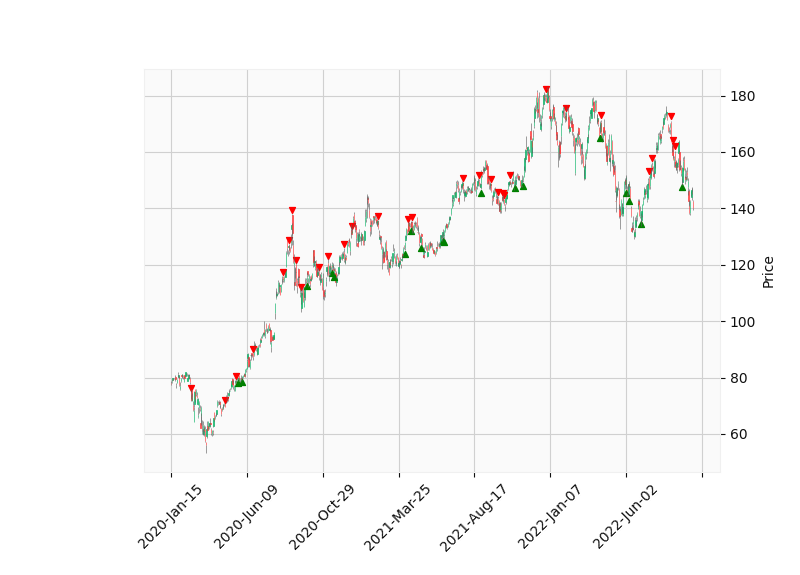

In [42]:
# Visualizing a pattern on candle stick chart

aapl_engulfing = aapl_patterns['CDLENGULFING']
aapl_engulfing_bullish = (aapl_engulfing.replace([-1,0],np.nan))*aapl_patterns.low*0.99
aapl_engulfing_bearish = (-aapl_engulfing.replace([1,0],np.nan))*aapl_patterns.high*1.01
%matplotlib ipympl
addplot = [mpf.make_addplot(aapl_engulfing_bullish,type='scatter',color = 'g',marker = '^'), 
            mpf.make_addplot(aapl_engulfing_bearish,type='scatter',color = 'r',marker = 'v')]
mpf.plot(aapl_patterns.iloc[:,:5],addplot=addplot,type='candle',style= 'yahoo')

In [8]:
top_100[:10]

NameError: name 'top_100' is not defined

In [10]:
# Pattern based signal generation
top_buy,top_sell=get_pattern_signals(tickers=top_100,top=5)

Top Buy Ideas
ticker
V      0.098361
TJX    0.098361
PGR    0.081967
COP    0.065574
DE     0.032787
dtype: object
Top Sell Ideas
ticker
VZ     -0.081967
ELV    -0.065574
CRM    -0.065574
AMD    -0.065574
AVGO    -0.04918
dtype: object
